# Wishart distribution tests
    
See https://github.com/scipy/scipy/blob/master/scipy/stats/_multivariate.py

Note: The mean of the Wishart distribution $W_p(\Sigma, \nu)$
is $\nu \Sigma$, not $\Sigma$ as stated in eq. (17) of TJK13.

In [1]:
import scipy.stats._multivariate as mv
import numpy as np
import matplotlib.pylab as plt

## The following is an alternative definition of a Wishart random variable.

## Covariance and precision matrix.

In [2]:
# Dimension of data vector, p in the paper
n_D = 10

In [3]:
# Variance = diagonal of the covariance matrix
sig2 = 1

In [4]:
cov     = np.diag([sig2 for i in range(n_D)])
cov_inv = np.diag([1/sig2 for i in range(n_D)])

In [5]:
def alpha(n_S, n_D):
    """Returns alpha, debiasing factor for inverse covariance"""
    
    return (n_S - n_D - 2) / (n_S - 1)

In [6]:
a_n_S = []
a_trN_est = []
a_trN_m1_est = []
a_trN_m1_est2 = []

for n_S in range(n_D+5, 50, 1):
    W = mv.wishart(df=n_S-1, scale=cov)
    
    # The mean of a Wishart distribution in 1D is nu. Therefore,
    # we need to divide by nu=n_S-1 (?)
    cov_est = W.rvs() / (n_S-1)
    
    ## Covariance matrix
    
    # The division by n_D is to get the normalised trace.
    trN_est = np.trace(cov_est) / n_D
            
    ## Precision matrix 1: numerically invert covariance
    cov_est_inv = np.linalg.inv(cov_est)
    trN_m1_est = np.trace(cov_est_inv) / n_D
        
    ## Precision matrix 2: sample from inverse Wishart distribution
    Wm1 = mv.invwishart(df=n_S-1, scale=cov_inv)
    cov_est_inv2 = Wm1.rvs()
    trN_m1_est2 = np.trace(cov_est_inv2) * n_S / n_D
        
    a_n_S.append(n_S)
    a_trN_est.append(trN_est)
    a_trN_m1_est.append(trN_m1_est)
    a_trN_m1_est2.append(trN_m1_est2)

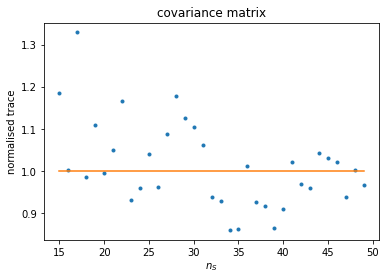

In [7]:
plt.plot(a_n_S, a_trN_est, '.', a_n_S, [sig2 for n_S in a_n_S])
plt.xlabel('$n_S$')
plt.ylabel('normalised trace')
plt.title('covariance matrix')
plt.show()

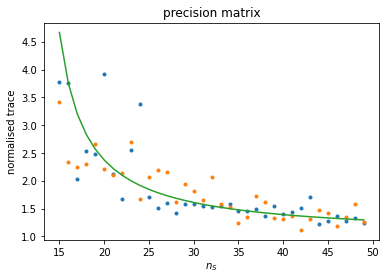

In [8]:
plt.plot(a_n_S, a_trN_m1_est, '.', \
         a_n_S, a_trN_m1_est2, '.', \
         a_n_S, [1/alpha(n_S, n_D) / sig2 for n_S in a_n_S])
plt.xlabel('$n_S$')
plt.ylabel('normalised trace')
plt.title('precision matrix')
plt.show()

## Plotting the Wishart distribution.

In [9]:
from scipy.stats import multivariate_normal

In [10]:
def get_cov_ML(cov, size):

    n_D = cov.shape[0]
    y2 = multivariate_normal.rvs(mean=np.zeros(n_D), cov=cov, size=size)
    # y2[:,j] = realisations for j-th data entry
    # y2[i,:] = data vector for i-th realisation

    # Calculate covariance matrix via np
    cov_est = np.cov(y2, rowvar=False)
    return cov_est

In [11]:
n_S = 20
n_R = 1000
i=0
j=0
# Correction of scale matrix (true covariance) to match ML cov estimate
cov_c = cov / (n_S - 1)

In [12]:
W = mv.wishart(df=n_S-1, scale=cov_c)
wij = []
for r in range(n_R):
    w = W.rvs()
    wij.append(w[i][j])

In [13]:
cij = []
for r in range(n_R):
    c = get_cov_ML(cov, n_S) 
    cij.append(c[i][j])

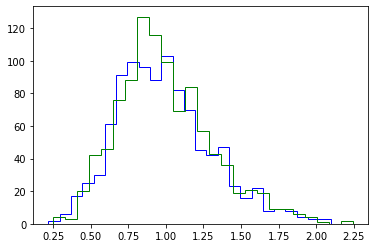

In [14]:
if n_S > n_D:
    plt.hist(wij, bins=25, histtype='step', color='b')
plt.hist(cij, bins=25, histtype='step', color='g')
plt.show()

### Comparing mean and variance

The mean of the Wishart distribution ${\cal W}_p\left(S, \nu\right)$ with $p \times p$ scale matrix $S$ and degrees of freedom $\nu$ is

$\langle \hat S \rangle = \nu S$.

The mean of the inverse Wishart distribution ${\cal W}_p^{-1}\left(T, \nu\right)$ is

$\langle \hat T \rangle = (\nu - p - 1)^{-1} T$.

The covariance matrix $\hat C$ as estimated from $n_{\rm s} = \nu + 1$ Gaussian random fields with true covariance matrix $C$ follows the distribution ${\cal W}_p(S = \nu^{-1} \, C, \nu)$.

The inverse of this estimated covariance, $\hat \psi = {\hat C}^{-1}$, has a biased mean,

$\alpha^{-1} C^{-1} = (\nu - p - 1)^{-1} \nu \, C^{-1}$.

It follows the inverse Wishart distribution ${\cal W}_p^{-1}\left( T = \nu \, C^{-1}, \nu\right)$.


The variance of the Wishart distribution is (on the diagonal)

$\langle (\Delta \hat S_{ii})^2 \rangle = 2 \nu S_{ii}^2 = 2 \nu^{-1} \, C_{ii}^2.$


The variance of the inverse Wishart distribution is (on the diagonal)

$(\Delta \hat T_{ii})^2 = 2 (\nu - p -3)^{-1} (\nu - p - 1)^{-2} \, T_{ii}^2 = 2 (\nu - p -3)^{-1} (\nu - p - 1)^{-2} \nu^2 \, C_{ii}^{-2} = 2 (\nu - p -3)^{-1} \, \alpha^{-2} \, C_{ii}^{-2} = 2 \beta \, \alpha^{-2} \, (\nu - p) \, C_{ii}^{-2},$

where in the last step we use

$\beta = (\nu - p)^{-1} (\nu - p -3)^{-1}.$

In [15]:
mean_true = cov[i][j] / (n_S - 1) * (n_S - 1)
var_true   = (cov[i][j]**2 + cov[i][i]*cov[j][j]) / (n_S - 1)
if n_S > n_D:
    mean_wij  = np.mean(wij)
    var_wij   = np.var(wij)
else:
    mean_wij = 'undef'
    var_wij  = 'undef'
mean_cij  = np.mean(cij)
var_cij   = np.var(cij)
print(mean_true, mean_wij, mean_cij)
print(var_true, var_wij, var_cij)

1.0 0.9878718921672486 0.9983633209390387
0.10526315789473684 0.10200865778156255 0.10010541455161956


## Plot of mean and variance as function of n_S

In [16]:
n_S_arr = []
for n_S in range(2, n_D, 1):
    n_S_arr.append(n_S)
for n_S in range(n_D, 2*n_D, 2):
    n_S_arr.append(n_S)
for n_S in range(2*n_D, 5*n_D, 10):
    n_S_arr.append(n_S)
for n_S in range(5*n_D, 20*n_D, 20):
    n_S_arr.append(n_S)

### Numerical mean and variance

In [17]:
var_c   = []
var_w   = []
mask_w  = []
for n_S in n_S_arr:
    
    cij = []
    for r in range(n_R):
        c = get_cov_ML(cov, n_S) 
        cij.append(c[i][j])
        
    wij = []    
    if n_S > n_D:
        W = mv.wishart(df=n_S-1, scale=cov / (n_S - 1))
        for r in range(n_R):
            w = W.rvs()
            wij.append(w[i][j])
            
    var_c.append(np.var(cij))
    
    if n_S > n_D:
        var_w.append(np.var(wij))
        mask_w.append(0)
    else:
        var_w.append(-1)
        mask_w.append(1)
        
var_mw  = np.ma.masked_array(var_w, mask=mask_w)

### Numerical variance of inverse covariance

In [18]:
var_inv_c     = []
var_inv_deb_c = []
var_inv_w     = []
mask_c = []
mask_w  = []
for n_S in n_S_arr:
    
    if n_S > n_D:
        cij = []
        cij_deb = []
        for r in range(n_R):
            c = get_cov_ML(cov, n_S)
            # No de-biasing here
            psi = np.linalg.inv(c)
            cij.append(psi[i][j])
            cij_deb.append(psi[i][j] * alpha(n_S, n_D))

        var_inv_c.append(np.var(cij))
        var_inv_deb_c.append(np.var(cij_deb))
        mask_c.append(0)
    else:
        var_inv_c.append(-1)
        var_inv_deb_c.append(-1)
        mask_c.append(1)
        
    df = n_S - 1
    if df > n_D:
        wij = []
        W = mv.invwishart(df=df, scale=cov_inv * (n_S - 1))
        for r in range(n_R):
            w = W.rvs()
            wij.append(w[i][j])
    
        var_inv_w.append(np.var(wij))
        mask_w.append(0)  
    else:
        var_inv_w.append(-1)
        mask_w.append(1)
        
var_inv_mc  = np.ma.masked_array(var_inv_c, mask=mask_c)
var_inv_deb_mc = np.ma.masked_array(var_inv_deb_c, mask=mask_c)
var_inv_mw  = np.ma.masked_array(var_inv_w, mask=mask_w)

### True variance

In [19]:
var_tr  = []
n_S_fine = np.arange(n_S_arr[0], n_S_arr[-1], len(n_S_arr)/100.0)
for n_S in n_S_fine:
    var_tr.append(1/(n_S - 1) * (cov[i][j]**2 + cov[i][i]*cov[j][j]))

### True variance of inverse covariance

In [20]:
var_inv_tr  = []
var_inv_deb_tr = []
mask = []
for n_S in n_S_fine:
    if n_S > n_D + 4:
        vi = 2 / (n_S - n_D - 4) / alpha(n_S, n_D)**2 * cov_inv[i][i]**2
        var_inv_tr.append(vi)
        var_inv_deb_tr.append(vi * alpha(n_S, n_D)**2)
        mask.append(0)
    else:
        var_inv_tr.append(-1)
        var_inv_deb_tr.append(-1)
        mask.append(1)
var_inv_trw  = np.ma.masked_array(var_inv_tr, mask=mask)
var_inv_deb_trw  = np.ma.masked_array(var_inv_deb_tr, mask=mask)

In [49]:
import matplotlib as mpl

mpl.rcParams['font.size'] = 14

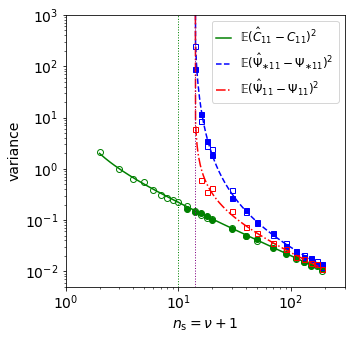

In [64]:
plt.figure(figsize=(5,5))
ax = plt.subplot(1, 1, 1)

plt.plot(n_S_arr, var_mw, 'go')
plt.plot(n_S_arr, var_c, 'go', mfc='none')
plt.plot(n_S_fine, var_tr, 'g-', \
         label='$\mathrm{\mathbb{E}}(\hat{C}_{11} - C_{11})^2$')

plt.plot(n_S_arr, var_inv_mw, 'bs', markersize=5)
plt.plot(n_S_arr, var_inv_mc, 'bs', mfc='none', markersize=5)
plt.plot(n_S_fine, var_inv_trw, 'b--', \
         label='$\mathrm{\mathbb{E}}(\hat{\Psi}_{\\ast 11} - \Psi_{\\ast 11})^2$')

plt.plot(n_S_arr, var_inv_deb_mc, 'rs', mfc='none', markersize=5)
plt.plot(n_S_fine, var_inv_deb_trw, 'r-.', \
         label='$\mathrm{\mathbb{E}}(\hat{\Psi}_{11} - \Psi_{11})^2$')


ax.set_xscale('log')
ax.set_yscale('log')

plt.xlim(1, 30*n_D)
plt.ylim(5e-3, 1e3)
ylim = plt.ylim()
plt.legend(loc='upper right', fontsize=12, handlelength=1.2)

plt.xlabel('$n_{\\rm s} = \\nu + 1$')
plt.ylabel('variance')

plt.plot([n_D, n_D], ylim, 'g:', linewidth=1)
plt.plot([n_D+4, n_D+4], ylim, ':', color='purple', linewidth=1)

plt.savefig('W.pdf', bbox_inches='tight')
plt.show()

/home/mkilbing/.local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: UserWarning: Warning: converting a masked element to nan.
  ary = asanyarray(ary)


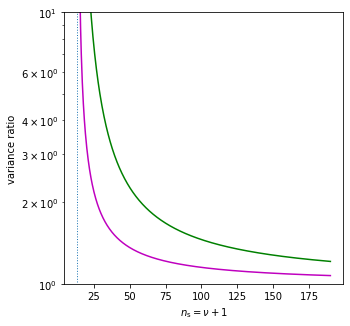

In [22]:
plt.figure(figsize=(5,5))
ratio = [y/x for (x, y) in zip(var_tr, var_inv_trw)]
plt.plot(n_S_fine, ratio, 'g', label='ratio')
ratio_deb = [y/x for (x,y) in zip(var_tr, var_inv_deb_trw)]
plt.plot(n_S_fine, ratio_deb, 'm', label='ratio deb')
plt.plot([n_D+3, n_D+3], ylim, ':', linewidth=1)
ax = plt.subplot(1, 1, 1)
#ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(1, 10)
#plt.xlim(10, 500)
plt.xlabel('$n_{\\rm s} = \\nu + 1$')
plt.ylabel('variance ratio')
plt.show()